# 2. Preprocessing (전처리)

데이터를 머신러닝 모델에 피팅시키기 이전에 전처리가 필요하다.

스케일링을 통해 변수간 영향력이 동일하게끔 만들어줘야 하며,
- 스케일링과 관계없는 모델도 많긴 하지만, 필요한 경우도 있으므로 그냥 해준다 (클러스터링으로 새로운 변수를 만드는 경우...등등)

범주형/서열 변수의 경우 컴퓨터가 이해할 수 있도록 숫자로 바꿔주고, 원핫인코딩 등의 전처리 과정을 거쳐야한다.

변수 하나하나의 속성을 파악하며 신중하게 이루어져야하는 작업이지만, 이번 실습에서는 대략적인 흐름을 파악하고 간략하게나마 전처리를 진행해보자

실제 분석 상황이라면 EDA에서 얻은 정보를 바탕으로 더욱 자세하게 살펴보도록 하자

**`0.문제정의`** 에서 저장한 파일을 불러와서 전처리를 해보자

-- `Train`과 `Test`에 똑같이 적용해야한다

-------------
# Wage prediction

현대축구에서는 우수한 측면수비수를 보유한 팀이 세계를 지배한다. 

피파 게임 데이터를 이용하여 누가 과연 좋은 측면수비수일지 예측해보자.  

물론 평가기준은... **돈(Wage)**이다!!  
**(프로는 돈으로 말한다)**

- Target : `Wage`
- Metric : `mse`
- Player : only.. 측면수비.. `RB`, `RWB`, `LB`, `LWB`
- Dataset: `FIFA 19`
- Remark : 상위 1000명의 선수를 `train:test=7:3`의 비율로 나누어 실습

----------------------
# 모듈

In [1]:
import os
import sys
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import re
from time import sleep

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#그래프 폰트 전역 설정
plt.style.use('seaborn')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'calibri'
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelsize']   = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['xtick.labelsize'] = 16


from scipy import stats

import sklearn

------------------
# 데이터 불러오기

In [2]:
# 디렉토리 내 파일 확인
os.listdir()

['.git',
 '.ipynb_checkpoints',
 '0. 문제 정의.ipynb',
 '1. EDA.ipynb',
 '2. Preprocessing.ipynb',
 'Cross Validation.ipynb',
 'EDA - 복사본.ipynb',
 'fifa19.csv',
 'fifa_wage_prediction.xlsx',
 'Kmeans 연습.ipynb',
 'LICENSE',
 'Linear Regression.ipynb',
 'Log transformation.ipynb',
 'PCA 실전.ipynb',
 'PCA 연습.ipynb',
 'players_20.csv',
 'README.md',
 'SVM.ipynb',
 'test_prep.csv',
 'train_prep.csv',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 'Untitled2.ipynb',
 '나만의 EDA_FIFA.ipynb',
 '코사인 유사도 연습.ipynb',
 '피파 머신러닝 연습(EDA).ipynb',
 '피파 머신러닝 흐름잡기.ipynb',
 '피파 머신러닝.zip']

In [3]:
fifa = pd.read_excel('fifa_wage_prediction.xlsx')
fifa.head(2)

,Wage,Value,Name,Age,Nationality,Overall,Club,Preferred Foot,International Reputation,Weak Foot,...,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,feet,inch
0,285,€43M,Marcelo,30,Brazil,88,Real Madrid,Left,4,4,...,85,85,82,59,86,71,85,86,5,9
1,250,€38M,Jordi Alba,29,Spain,87,FC Barcelona,Left,3,3,...,84,79,70,59,79,72,84,85,5,7


-----------------
# X_train, X_test / y_train, y_test 분리

- Overall 능력치 순 상위 1000명의 data를 7:3 비율로 `train set`과 `test set`으로 분리

- `random_state=1`로 고정하여 `shuffle`

- `train set`을 이용하여 모델을 만들어보고, `test set`은 최종결과를 확인할 때만 사용

In [4]:
from sklearn.model_selection import train_test_split

# 능력치 순 상위 n명만 분리
n = 1000

X   = fifa.loc[:n,['Name', 'Age','Nationality','Overall', 'Club',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From',
       'Height', 'Weight',
       'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']]

# Wage 전처리 (숫자로 변환)
y = fifa.loc[:n,['Wage']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,shuffle=True)

`train`과 `test`를 똑같이 변형해줘야하기 때문에 list로 묶어 한번에 처리하자

In [5]:
tt = [X_train, X_test]

------------------------
# 전처리

In [6]:
# 수치형변수 스케일링
# 범주형 변수 처리
# 이왕이면 범주형 변수도 같은 범위 안에 있도록 해주기

In [7]:
# Dtype 확인 (수치형 or 범주형)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 432 to 37
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      700 non-null    object 
 1   Age                       700 non-null    int64  
 2   Nationality               700 non-null    object 
 3   Overall                   700 non-null    int64  
 4   Club                      688 non-null    object 
 5   Preferred Foot            700 non-null    object 
 6   International Reputation  700 non-null    int64  
 7   Weak Foot                 700 non-null    int64  
 8   Skill Moves               700 non-null    int64  
 9   Work Rate                 700 non-null    object 
 10  Body Type                 700 non-null    object 
 11  Real Face                 700 non-null    object 
 12  Position                  700 non-null    object 
 13  Jersey Number             700 non-null    int64  
 14  Joined   

## Scaling - Numerical Variable

In [8]:
# 수치형 변수 정의하기
numerical_variable = ['Age', 'Height', 'Weight', 'Crossing', 'Finishing',
                      'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
                      'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
                      'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
                      'Marking', 'StandingTackle', 'SlidingTackle']

In [9]:
X_train_numerical = X_train.loc[:,numerical_variable]
X_test_numerical = X_test.loc[:,numerical_variable]
X_train_numerical.head()

,Age,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
432,34,187.96,76.2048,75,57,68,72,66,74,74,...,73,82,64,69,65,62,67,68,68,69
671,29,177.80,78.0192,71,35,63,61,53,62,34,...,46,74,73,53,35,61,65,65,65,66
641,23,175.26,68.9472,73,60,56,70,49,71,51,...,50,63,61,68,60,47,58,64,66,65
805,24,185.42,69.8544,71,27,68,69,43,62,64,...,23,64,68,54,51,38,66,65,68,73
920,23,177.80,77.1120,71,33,58,64,25,67,72,...,32,60,64,67,55,46,60,68,73,70


In [10]:
tt_numerical = [X_train_numerical, X_test_numerical]

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

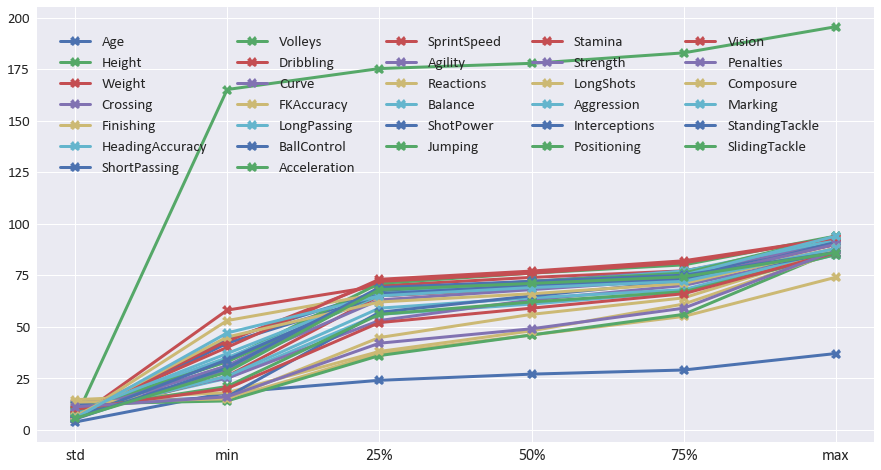

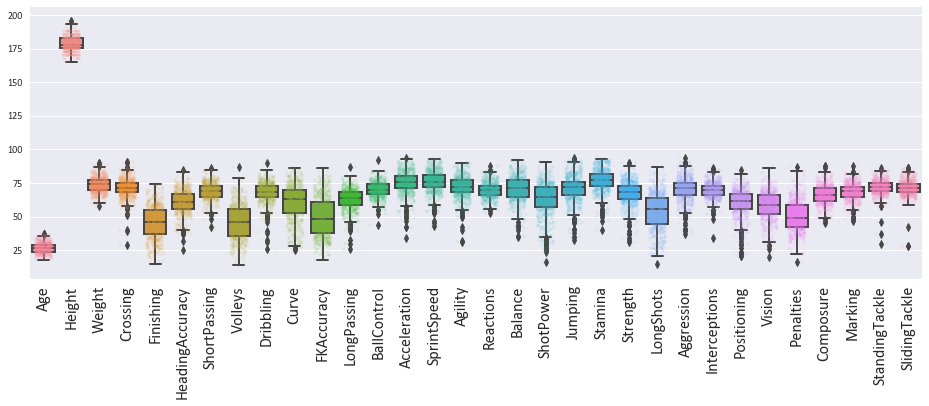

In [12]:
X_train_numerical.describe().iloc[2:].plot(figsize=(15,8), marker='X', ms=10)
plt.legend(loc= (0.02,0.6) , fontsize=15, ncol=5, framealpha=0)
plt.yticks(fontsize=15)

plt.figure(figsize = (16,5))
sns.boxplot(data = X_train_numerical, linewidth=2)
sns.stripplot(data = X_train_numerical, linewidth=0, size=3, jitter=0.3, alpha=0.1)
plt.xticks(rotation=90)
plt.show()

Scaling을 해보자

In [13]:
# min-max는 out-lier에 민감 / sparse feature에는 효과적일 수 있음
# MaxAbs - sparse data에 사용 권장
# MinMaxScaler   Normalizer       MaxAbsScaler        StandardScaler
# RobustScaler   PowerTransformer QuantileTransformer

scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_test_numerical_scaled = scaler.transform(X_test_numerical)

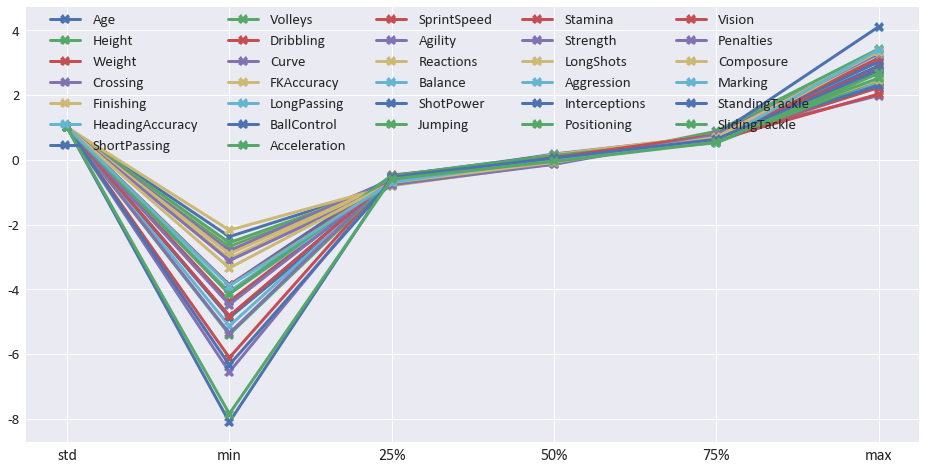

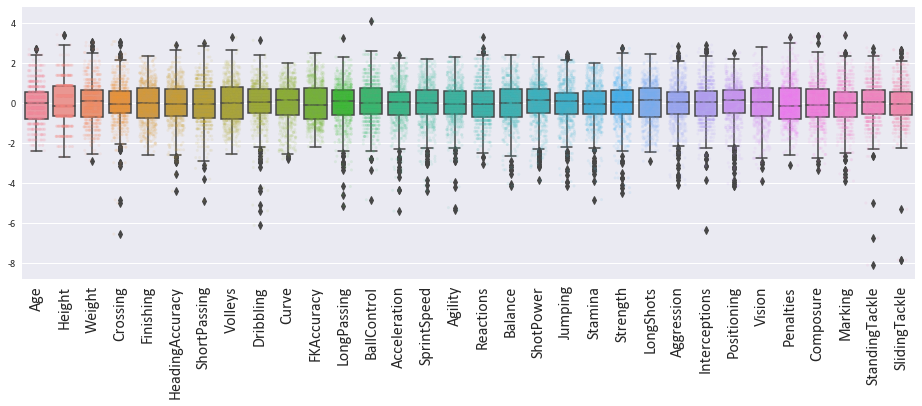

In [14]:
# min-max는 out-lier에 민감
# MinMaxScaler   Normalizer       MaxAbsScaler        StandardScaler
# RobustScaler   PowerTransformer QuantileTransformer

df = X_train_numerical_scaled
df2 = X_test_numerical_scaled

df = pd.DataFrame(df)
df2 = pd.DataFrame(df2)

df.columns = X_train_numerical.columns
df2.columns = X_test_numerical.columns

tt_numerical[0] = df
tt_numerical[1] = df2

df.describe().iloc[2:].plot(figsize=(16,8), marker='X', ms=10)
plt.legend(loc= (0.02,0.65) , fontsize=15, ncol=5, framealpha=0)
plt.yticks(fontsize=15)
plt.show()

plt.figure(figsize = (16,5))
data = df
sns.boxplot(data = data, linewidth=1.5)
sns.stripplot(data = data, linewidth=0, size=3, jitter=0.3, alpha=0.1)
plt.xticks(rotation=90)
plt.show()

## Encoding Catergorical Variable

In [15]:
from sklearn.feature_extraction import DictVectorizer #categorical을 원핫인코딩해줌
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder #cat-변수를 int형으로 변환 (걍 넣으면 숫자로 인식함 - 주의)
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import Binarizer #treshold에 따라 0과 1로 구분
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.preprocessing import PolynomialFeatures # generate polynomial feature
from sklearn.preprocessing import FunctionTransformer #원하는 식으로 변환


from sklearn.impute import SimpleImputer #결측값 처리
from sklearn.impute import KNNImputer

In [16]:
# 범주형/서열 변수 정의하기
# Club 제외 - 전처리 오래걸림 / but 다양한 아이디어 제시 가능
cat_variable = ['Nationality','Club', 'Preferred Foot',
                'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
                'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Joined',
                'Loaned From']

In [17]:
X_train_cat = X_train.loc[:,cat_variable]
X_test_cat = X_test.loc[:,cat_variable]

tt_cat = [X_train_cat, X_test_cat] 

### `Nationality ` : 국적

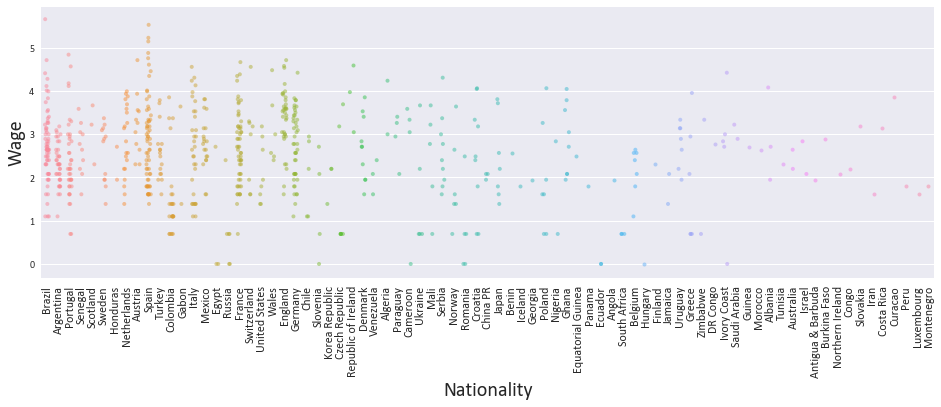

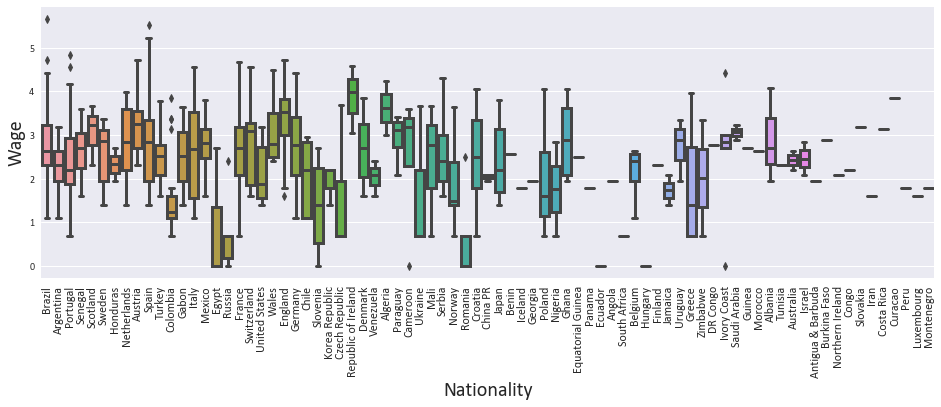

In [18]:
plt.figure(figsize = (16,5))
y = np.log1p(y_train.Wage)
sns.stripplot(x=X_train.Nationality, y=y, linewidth=0, size=4, jitter=0.2, alpha=0.5)
plt.xticks(rotation=90, fontsize=12)
plt.show()

plt.figure(figsize = (16,5))
sns.boxplot(x=X_train.Nationality, y=y)
plt.xticks(rotation=90, fontsize=12)
plt.show()

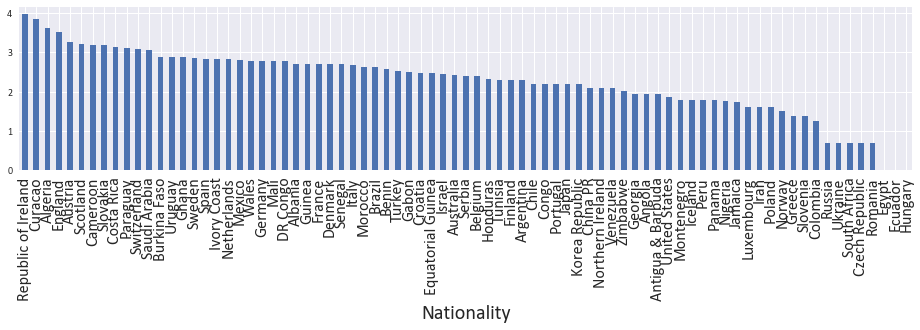

In [19]:
plt.figure(figsize=(16,3))
y = np.log1p(y_train.Wage)
y.groupby(X_train.Nationality).median().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

 중앙값 기준으로 나열해서 국가별로 등급을 매겨보자

대륙별로 묶는 등 다양한 방법이 있겠지만, 합리적인 처리방안이 딱히 떠오르지 않게 때문에 우선 이 변수는 제외하고 진행해보자

### - `Club`
- 너무 다양한 클럽들이 있으므로 이 또한 제외해보자

In [20]:
X_train.Club.value_counts()

Leicester City            5
RB Leipzig                5
Crystal Palace            5
Cardiff City              5
VfL Wolfsburg             5
                         ..
PFC CSKA Moscow           1
Club Atlético Talleres    1
Rosenborg BK              1
New York City FC          1
Norwich City              1
Name: Club, Length: 349, dtype: int64

### - `Preferred Foot`: 선호하는 발
### - `Weak Foot`: 반대발 사용 능력

    - Preferred Foot
        - 0,1 로 인코딩
    - Weak Foot
        - 성민석 형꺼 보고 따라하기

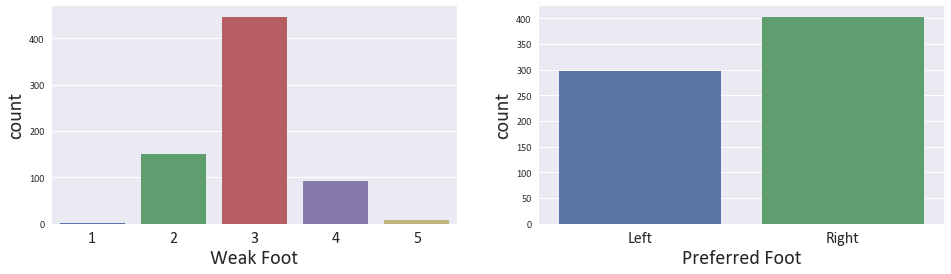

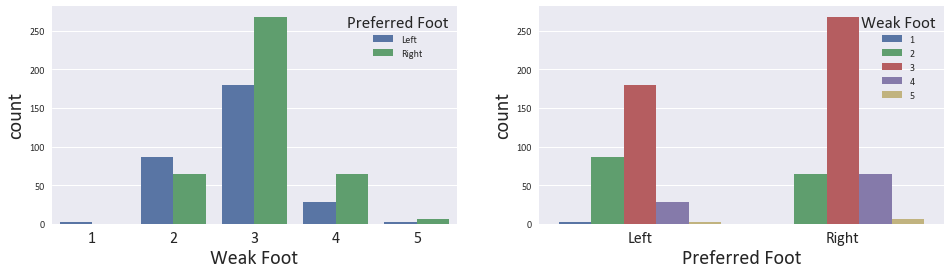

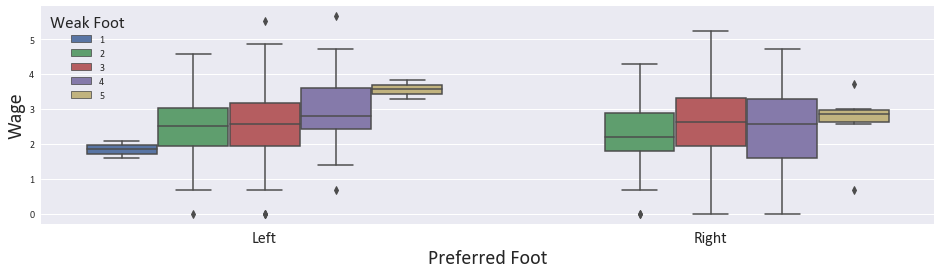

In [21]:
 # Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)
sns.countplot(X_train['Weak Foot'], ax=axes[0])
sns.countplot(X_train['Preferred Foot'], ax=axes[1])

f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)
sns.countplot(X_train['Weak Foot'], hue=X_train['Preferred Foot'], ax=axes[0])
sns.countplot(X_train['Preferred Foot'], hue=X_train['Weak Foot'], ax=axes[1])

plt.figure(figsize = (16,4))
data = X_train['Preferred Foot']
y = np.log1p(y_train.Wage)
sns.boxplot(x = data, y=y , hue = X_train['Weak Foot'], linewidth=1.5)

#plt.figure(figsize = (16,4))
#data = X_train['Weak Foot']
#y = y = np.log1p(y_train.Wage)
#sns.boxplot(x = data, y=y , hue = X_train['Preferred Foot'], linewidth=1.5)

- `Weak Foot`은 이미 numerical value이기 때문에 그대로 두자
- `preferred Foot`은 0, 1로 인코딩 해보자
    - 왼발 선수들은 양발에 능숙할수록 Wage가 올라가는 반면, 오른발 선수들에겐 그런 경향이 덜하다
    - 직접 지정하여 값을 바꾸어도 되고 ***Scikit Learn***에서 지원하는 `Label Encoder`를 사용해도 된다
    - 두가지 분류(left/right)밖에 없기 때문에 0,1로 바꾸기만 하면 일단 완료

In [22]:
X_train['Preferred Foot'].head()

432     Left
671     Left
641    Right
805     Left
920     Left
Name: Preferred Foot, dtype: object

In [23]:
# 직접 지정하여 값을 바꾸어도 되고 사이킷런에서 지원하는 label Encoder를 사용해도 된다
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(X_train['Preferred Foot'])

for df in tt_cat :
    df['Preferred Foot'] = label_encoder.transform(df['Preferred Foot'])

X_train_cat['Preferred Foot'].head()

432    0
671    0
641    1
805    0
920    0
Name: Preferred Foot, dtype: int32

### - `International Reputaion`: 국제적 명성

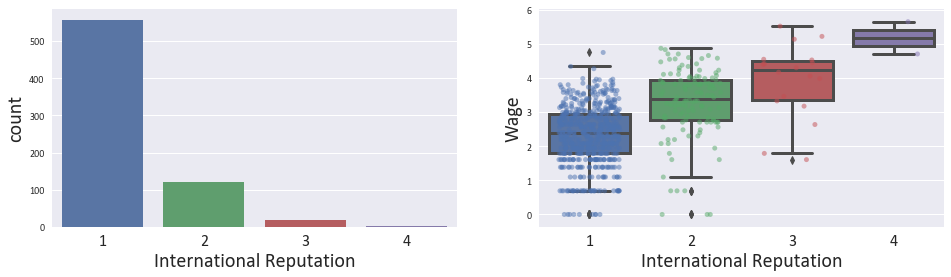

In [24]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['International Reputation']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data,y, ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])

- wage와 관계가 있어보이고, 이미 numerical value이기 때문에 형태는 유지하되, 최소값이 0이 되도록 변환해보자

In [25]:
X_train['International Reputation'].head()

432    1
671    1
641    1
805    1
920    1
Name: International Reputation, dtype: int64

In [26]:
repu_mapping = {1:0, 2:1, 3:2, 4:3, 5:4}

for df in tt_cat:
    df['International Reputation'] = df['International Reputation'].map(repu_mapping)

X_train_cat['International Reputation'].head()

432    0
671    0
641    0
805    0
920    0
Name: International Reputation, dtype: int64

### - `Skill Moves`: 개인기 능력

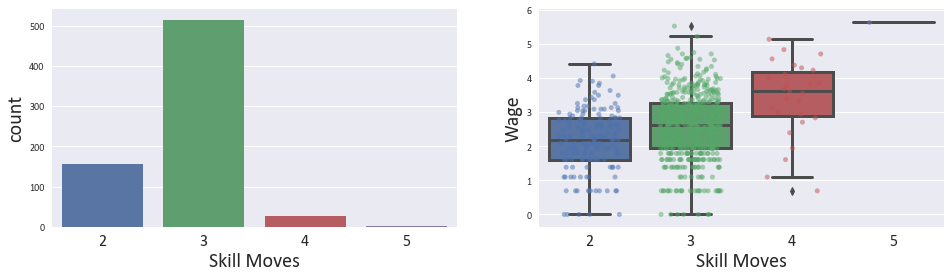

In [27]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Skill Moves']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data,y, ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])

In [28]:
X_train['Skill Moves'].head()

432    3
671    2
641    3
805    2
920    3
Name: Skill Moves, dtype: int64

In [29]:
skill_moves_mapping = {1:0, 2:1, 3:2, 4:3, 5:4}

for df in tt_cat:
    df['Skill Moves'] = df['Skill Moves'].map(skill_moves_mapping)

X_train_cat['Skill Moves'].head()

432    2
671    1
641    2
805    1
920    2
Name: Skill Moves, dtype: int64

### - `Work Rate`: 공격/수비 성향

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

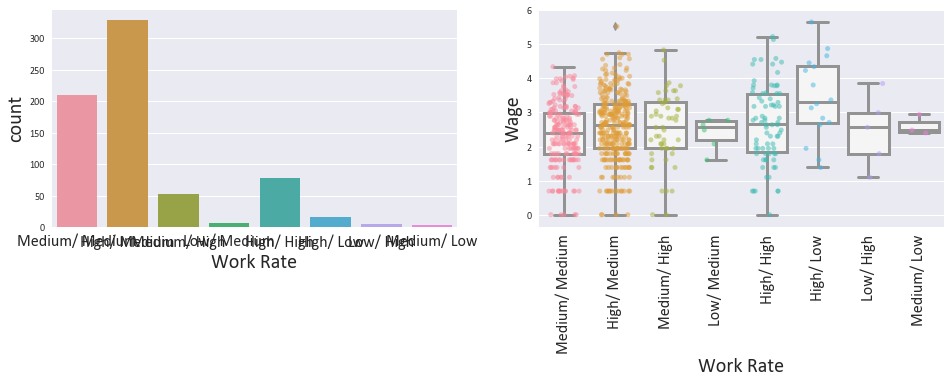

In [30]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Work Rate']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

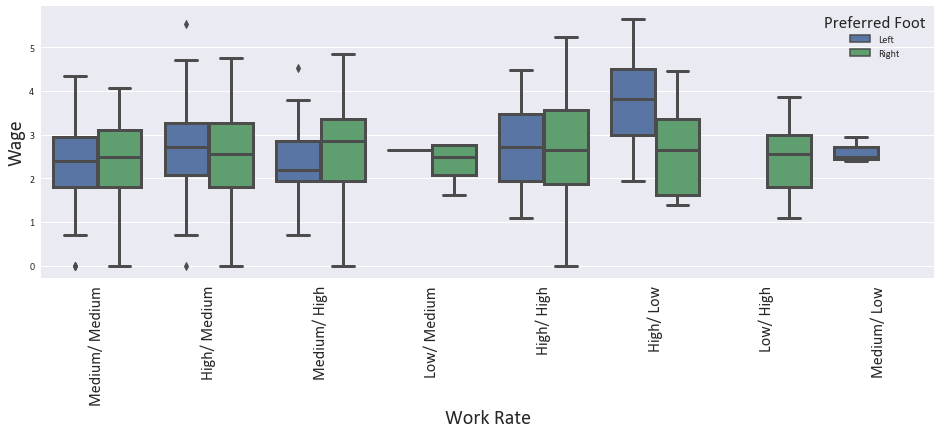

In [31]:
data = X_train['Work Rate']
y = np.log1p(y_train.Wage)
plt.figure(figsize=(16,5))
sns.boxplot(data, y, hue=X_train['Preferred Foot'])
plt.xticks(rotation=90)


- `/ `기호를 기준으로 나누고, 숫자형으로 변환을 해보자

In [32]:
# 이런식으로 한꺼번에 처리를 해보자
X_train['Work Rate'].str.split('/ ')

432    [Medium, Medium]
671      [High, Medium]
641      [High, Medium]
805    [Medium, Medium]
920      [Medium, High]
             ...       
767      [High, Medium]
72         [High, High]
908      [High, Medium]
235    [Medium, Medium]
37     [Medium, Medium]
Name: Work Rate, Length: 700, dtype: object

In [33]:
for df in tt_cat:
    df[['offense','defense']] = df['Work Rate'].str.split('/ ', n = 2, expand=True)
    
X_train_cat[['offense','defense']].head()

,offense,defense
432,Medium,Medium
671,High,Medium
641,High,Medium
805,Medium,Medium
920,Medium,High


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

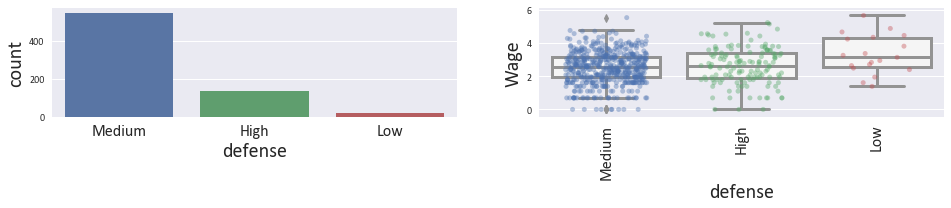

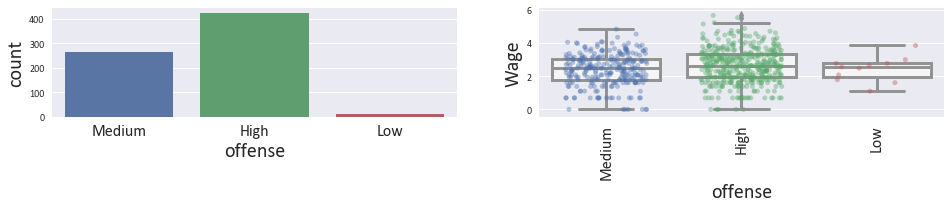

In [34]:
f, axes = plt.subplots(1, 2, figsize=(16, 2), sharex=False)

data = X_train_cat['defense']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.4, ax=axes[1])
plt.xticks(rotation=90)

###################################################
f, axes = plt.subplots(1, 2, figsize=(16, 2), sharex=False)

data = X_train_cat['offense']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.4, ax=axes[1])
plt.xticks(rotation=90)

원핫인코딩을 해줍니다
- 해당 변수가 갖고있는 카테고리의 갯수만큼 차원이 늘어난다는 단점이 있지만 일단 시도해봅시다.

In [35]:
# train
defense = pd.get_dummies(X_train_cat['defense'])
defense.columns = ['def_hi', 'def_low','def_mid']

offense = pd.get_dummies(X_train_cat['offense'])
offense.columns = ['off_hi', 'off_low','off_mid']

X_train_cat = pd.concat([X_train_cat, defense, offense], axis=1)

# test
defense = pd.get_dummies(X_test_cat['defense'])
defense.columns = ['def_hi', 'def_low','def_mid']

offense = pd.get_dummies(X_test_cat['offense'])
offense.columns = ['off_hi', 'off_low','off_mid']

X_test_cat = pd.concat([X_test_cat, defense, offense], axis=1)

In [36]:
X_train_cat.head(2)

,Nationality,Club,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,...,Joined,Loaned From,offense,defense,def_hi,def_low,def_mid,off_hi,off_low,off_mid
432,Brazil,Internacional,0,0,4,2,Medium/ Medium,Normal,No,LB,...,"Jan 1, 2018",NaN,Medium,Medium,0,0,1,0,0,1
671,Argentina,Unión de Santa Fe,0,0,3,1,High/ Medium,Normal,No,LB,...,"Jul 23, 2018",NaN,High,Medium,0,0,1,1,0,0


In [37]:
X_train_cat.head(2)

,Nationality,Club,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,...,Joined,Loaned From,offense,defense,def_hi,def_low,def_mid,off_hi,off_low,off_mid
432,Brazil,Internacional,0,0,4,2,Medium/ Medium,Normal,No,LB,...,"Jan 1, 2018",NaN,Medium,Medium,0,0,1,0,0,1
671,Argentina,Unión de Santa Fe,0,0,3,1,High/ Medium,Normal,No,LB,...,"Jul 23, 2018",NaN,High,Medium,0,0,1,1,0,0


원핫 인코딩 된 변수들을 training data set에 합쳐줍니다

In [38]:
tt_cat[0] = X_train_cat
tt_cat[1] = X_test_cat

### - `Body Type`: 체형

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

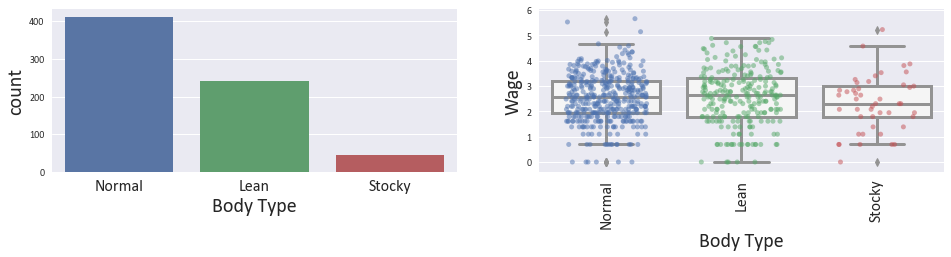

In [39]:
f, axes = plt.subplots(1, 2, figsize=(16, 3), sharex=False)

data = X_train['Body Type']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

다양한 변수들과 함꼐 이리저리 살펴봐야하지만 일단은 원핫인코딩을 해보자

In [40]:
# train
body = pd.get_dummies(X_train_cat['Body Type'])
body.columns = ['body_lean','body_normal','body_stocky']

X_train_cat = pd.concat([X_train_cat, body], axis=1)

# test
body = pd.get_dummies(X_test_cat['Body Type'])
body.columns = ['body_lean','body_normal','body_stocky']

X_test_cat = pd.concat([X_test_cat, body], axis=1)

In [41]:
X_train_cat.head(2)

,Nationality,Club,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,...,defense,def_hi,def_low,def_mid,off_hi,off_low,off_mid,body_lean,body_normal,body_stocky
432,Brazil,Internacional,0,0,4,2,Medium/ Medium,Normal,No,LB,...,Medium,0,0,1,0,0,1,0,1,0
671,Argentina,Unión de Santa Fe,0,0,3,1,High/ Medium,Normal,No,LB,...,Medium,0,0,1,1,0,0,0,1,0


In [42]:
X_test_cat.head(2)

,Nationality,Club,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,...,defense,def_hi,def_low,def_mid,off_hi,off_low,off_mid,body_lean,body_normal,body_stocky
951,Brazil,Bahia,1,0,2,1,Low/ Medium,Stocky,No,RB,...,Medium,0,0,1,0,1,0,0,0,1
635,Spain,Real Oviedo,1,0,2,2,High/ High,Normal,No,RB,...,High,1,0,0,1,0,0,0,1,0


In [43]:
tt_cat[0] = X_train_cat
tt_cat[1] = X_test_cat

### - `Real Face`

유명한 선수는 게임상에 페이스온이 되어있겠죠,,,

연습하는데 있어서 공정한 변수가 아니라고 판단하여 변수는 실습에서 제외하도록 하겠습니다.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

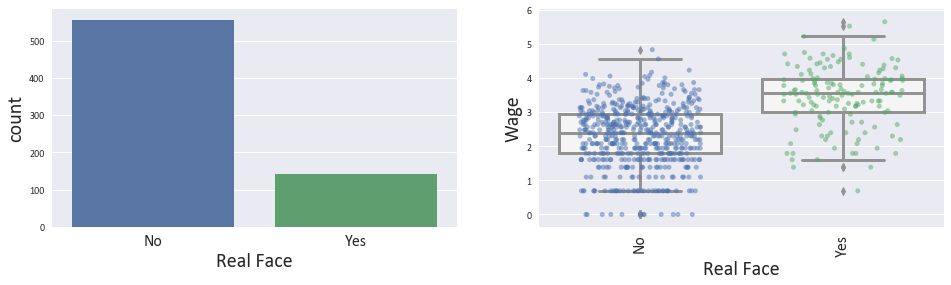

In [44]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Real Face']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

### - `Position`

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

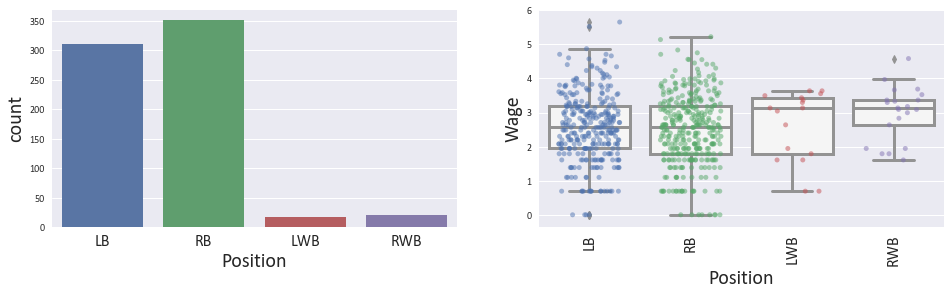

In [45]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Position']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

### - `Jersey Number`: 등번호

도메인 지식을 활용하여 전처리를 해보자.

보통 축구에서 측면수를 대표하는 번호는 2, 3번이다. 그렇다고 꼭 `Wage`가 높지는 않다..

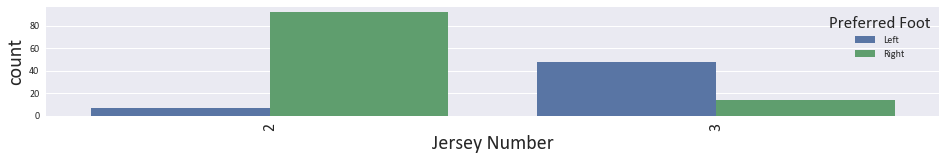

In [46]:
data = pd.concat([y_train['Wage'], X_train['Jersey Number']], axis=1)[X_train['Jersey Number'] < 4]

#f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = pd.concat([y_train['Wage'], X_train['Jersey Number']], axis=1)[X_train['Jersey Number'] < 4]
x = data['Jersey Number']
y = data.Wage

plt.figure(figsize=(16,2))
sns.countplot(x, hue = X_train['Preferred Foot'])
plt.xticks(rotation=90)
plt.show()

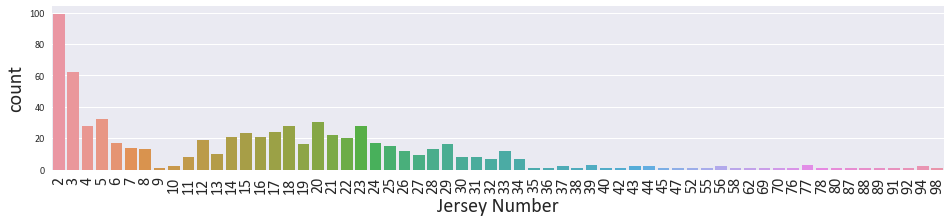

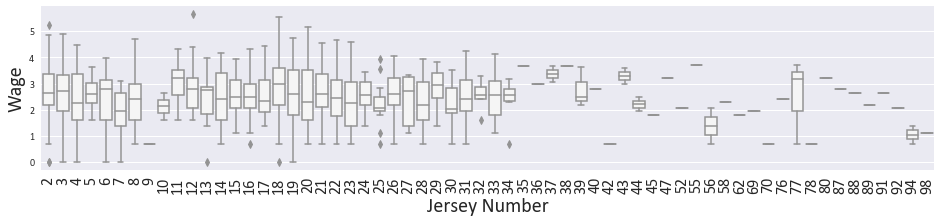

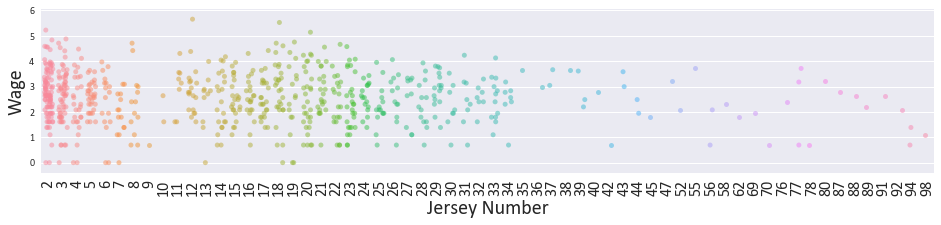

In [47]:
#f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Jersey Number']
y = np.log1p(y_train.Wage)

plt.figure(figsize=(16,3))
sns.countplot(data, )
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(16,3))
sns.boxplot(data, y ,color='#f5f5f5', linewidth=1.5)
#sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5)
plt.xticks(rotation=90)
plt.show()

data = X_train['Jersey Number']
y = np.log1p(y_train.Wage)
plt.figure(figsize=(16,3))
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5)
plt.xticks(rotation=90)
plt.show()

특별한 아이디어가 떠오르지 않아 2-4번까지는 팀에서 핵심적인 역할을 할 가능성이 높을 것이라 판단하여 다른번호들과 분리해서 그룹을 묶어보겠습니다

In [48]:
# map하고 apply 정리하기

In [49]:
tt_cat[0].columns

Index(['Nationality', 'Club', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Real Face',
       'Position', 'Jersey Number', 'Joined', 'Loaned From', 'offense',
       'defense', 'def_hi', 'def_low', 'def_mid', 'off_hi', 'off_low',
       'off_mid', 'body_lean', 'body_normal', 'body_stocky'],
      dtype='object')

In [50]:
# 키넘버에 속하면 1, 아니면 0
key_num = [2,3,4,5]

for df in tt_cat:
    df['num2cat'] = df['Jersey Number'].copy()
    df['num2cat'] = df['num2cat'].apply(lambda x:0 if x not in key_num else x)
    df['num2cat'] = df['num2cat'].apply(lambda x:1 if x in key_num else x)

X_train_cat['num2cat'].head()

432    0
671    1
641    0
805    1
920    0
Name: num2cat, dtype: int64

### - `Joined`

In [51]:
X_train['Joined'].head(10)

432     Jan 1, 2018
671    Jul 23, 2018
641     Jul 1, 2016
805     Jul 7, 2015
920    Aug 23, 2017
757     Jan 7, 2016
846    Aug 31, 2015
134    Aug 24, 2016
504     Jul 1, 2014
765     Jun 1, 2014
Name: Joined, dtype: object

날짜 정보가 들어있으므로 연도만 남겨보겠습니다

In [52]:
X_train['Joined'].str.split(',', expand = True)[1]

432     2018
671     2018
641     2016
805     2015
920     2017
       ...  
767     2018
72       NaN
908      NaN
235     2018
37      2017
Name: 1, Length: 700, dtype: object

In [53]:
#pd.tonumeric 정리하기
#결측값 처리
#fillna 정리하기

결측치에 일단 0을 채워넣고, 그림을 그려봅시다

In [54]:
join_year = X_train['Joined'].str.split(',', expand = True)
join_year = join_year[1]
join_year = pd.to_numeric(join_year)
join_year = join_year.fillna(0)
X_train['join_year'] = join_year
X_train['join_year']

432    2018.0
671    2018.0
641    2016.0
805    2015.0
920    2017.0
        ...  
767    2018.0
72        0.0
908       0.0
235    2018.0
37     2017.0
Name: join_year, Length: 700, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

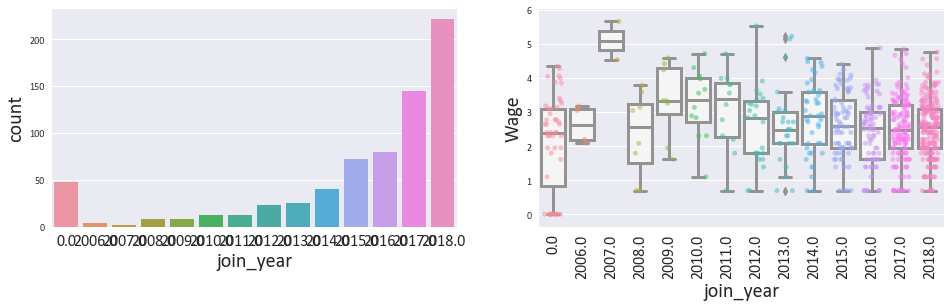

In [55]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['join_year']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

In [56]:
# train과 test에 해당 작업을 해줍니다

for df in tt_cat:
    join_year = df['Joined'].str.split(',', expand = True)
    join_year = join_year[1]
    join_year = pd.to_numeric(join_year)
    join_year = join_year.fillna(0)
    df['join_year'] = join_year
    df['join_year']
    
X_train_cat['join_year']

432    2018.0
671    2018.0
641    2016.0
805    2015.0
920    2017.0
        ...  
767    2018.0
72        0.0
908       0.0
235    2018.0
37     2017.0
Name: join_year, Length: 700, dtype: float64

null값에 대해서 중앙값으로 처리를 해주겠습니다

In [57]:
# 0에 null값을 다시 채우고 중앙값으로 대체
X_train['join_year'] = X_train['join_year'].apply(lambda x : np.nan if x==0 else x)
X_train['join_year'] = X_train['join_year'].apply(lambda x : X_train['join_year'].median() if np.isnan(x)==1 else x)
X_train['join_year']

432    2018.0
671    2018.0
641    2016.0
805    2015.0
920    2017.0
        ...  
767    2018.0
72     2017.0
908    2017.0
235    2018.0
37     2017.0
Name: join_year, Length: 700, dtype: float64

In [58]:
# train과 test에 해당 작업을 해줍니다

for df in tt_cat:
    df['join_year'] = df['join_year'].apply(lambda x : np.nan if x==0 else x)
    df['join_year'] = df['join_year'].apply(lambda x : df['join_year'].median() if np.isnan(x)==1 else x)
    
X_train_cat['join_year']

432    2018.0
671    2018.0
641    2016.0
805    2015.0
920    2017.0
        ...  
767    2018.0
72     2017.0
908    2017.0
235    2018.0
37     2017.0
Name: join_year, Length: 700, dtype: float64

In [59]:
# 2018년과의 차이를 구해서 현재 팀에 머무른 햇수를 구해봅니다.
X_train['stay_year'] = 2018 - X_train['join_year']
X_train['stay_year']

432    0.0
671    0.0
641    2.0
805    3.0
920    1.0
      ... 
767    0.0
72     1.0
908    1.0
235    0.0
37     1.0
Name: stay_year, Length: 700, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

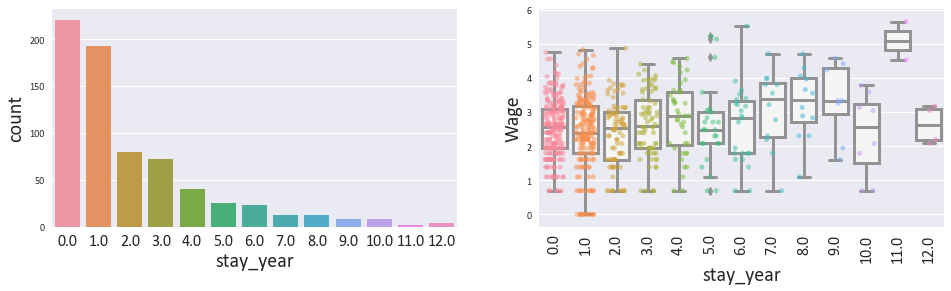

In [60]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['stay_year']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

In [61]:
# train과 test에 해당 작업을 해줍니다

for df in tt_cat:
    df['stay_year'] = 2018 - df['join_year']
    df['stay_year']
    
X_train_cat['stay_year'].head()

432    0.0
671    0.0
641    2.0
805    3.0
920    1.0
Name: stay_year, dtype: float64

팀에 옮겨왔을 때 선수의 나이를 나타내는 변수를 구해봅시다

아무래도 팀을 옮기면서 계약할 때 Wage에 영향을 미치지 않을까요?

In [62]:
X_train['join_age'] = X_train['Age']-X_train['stay_year']
X_train['join_age']

432    34.0
671    29.0
641    21.0
805    21.0
920    22.0
       ... 
767    30.0
72     28.0
908    19.0
235    36.0
37     23.0
Name: join_age, Length: 700, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text xticklabel objects>)

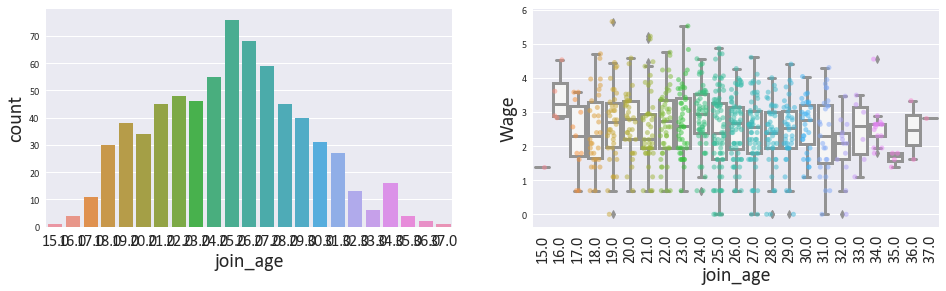

In [63]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['join_age']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

In [64]:
df.columns

Index(['Nationality', 'Club', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Real Face',
       'Position', 'Jersey Number', 'Joined', 'Loaned From', 'offense',
       'defense', 'def_hi', 'def_low', 'def_mid', 'off_hi', 'off_low',
       'off_mid', 'body_lean', 'body_normal', 'body_stocky', 'num2cat',
       'join_year', 'stay_year'],
      dtype='object')

In [65]:
# train과 test에 해당 작업을 해줍니다

for i, df in enumerate(tt_cat):
    df['join_age'] = tt_numerical[i]['Age']-df['stay_year']
    df['join_age']
    
X_train_cat['join_age'].head()

432    1.357135
671   -0.242182
641   -1.709076
805         NaN
920         NaN
Name: join_age, dtype: float64

수치상으로는 별 관련이 없어보입니다



구간별로 나눠서 처리(연습삼아)해보고, 널값은 median으로 채워보자 (연습)

### - `Loaned From`
    - 어느 팀에서 임대왔는지를 나타냄 - 몇명 없으니 제외하자

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

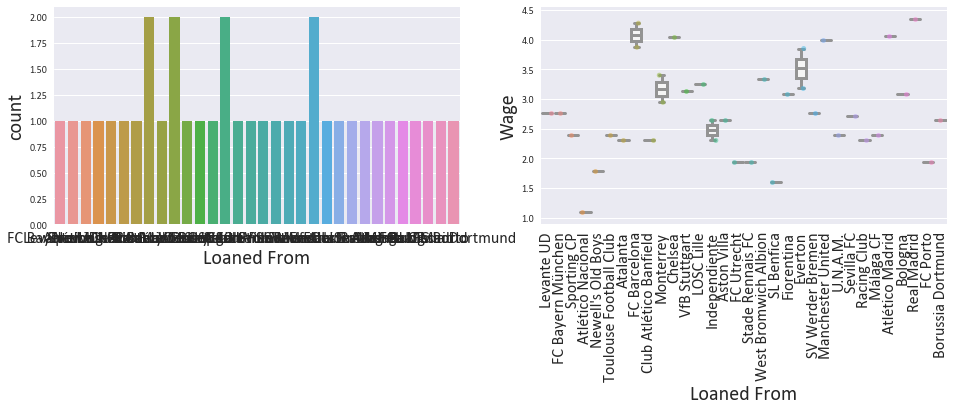

In [66]:
f, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=False)

data = X_train['Loaned From']
y = np.log1p(y_train.Wage)

sns.countplot(data, ax=axes[0])
sns.boxplot(data, y ,color='#f5f5f5', ax=axes[1])
sns.stripplot(data,y, linewidth=0, size=5, jitter=0.3, alpha=0.5, ax=axes[1])
plt.xticks(rotation=90)

----------


In [67]:
tt_cat[0].columns

Index(['Nationality', 'Club', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Real Face',
       'Position', 'Jersey Number', 'Joined', 'Loaned From', 'offense',
       'defense', 'def_hi', 'def_low', 'def_mid', 'off_hi', 'off_low',
       'off_mid', 'body_lean', 'body_normal', 'body_stocky', 'num2cat',
       'join_year', 'stay_year', 'join_age'],
      dtype='object')

데이터를 모델에 넣기 위하여, 최종적으로 숫자로 인코딩 한 변수만 남겨서 저장해봅시다

In [68]:
tt_cat[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 432 to 37
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Nationality               700 non-null    object 
 1   Club                      688 non-null    object 
 2   Preferred Foot            700 non-null    int32  
 3   International Reputation  700 non-null    int64  
 4   Weak Foot                 700 non-null    int64  
 5   Skill Moves               700 non-null    int64  
 6   Work Rate                 700 non-null    object 
 7   Body Type                 700 non-null    object 
 8   Real Face                 700 non-null    object 
 9   Position                  700 non-null    object 
 10  Jersey Number             700 non-null    int64  
 11  Joined                    652 non-null    object 
 12  Loaned From               36 non-null     object 
 13  offense                   700 non-null    object 
 14  defense  

In [69]:
for i, df in enumerate(tt_cat):
    df = df.loc[:,['Preferred Foot', 'International Reputation',
                    'Weak Foot', 'Skill Moves', 'Jersey Number', 
                    'def_hi', 'def_low', 'def_mid', 'off_hi', 'off_low',
                    'off_mid', 'body_lean', 'body_normal', 'body_stocky', 'num2cat',
                    'stay_year', 'join_age']]
  
    tt_cat[i] = df

In [70]:
train = pd.concat([tt_numerical[0], tt_cat[0]],axis=1)
test  = pd.concat([tt_numerical[1], tt_cat[1]],axis=1)

저장해줍니다

In [ ]:
reset index 해야함...

In [71]:
train.to_csv('train_prep.csv', index=False)
test.to_csv('test_prep.csv', index=False)